# Quantum Key Distribution
We want to be able to distrubute cryptographic keys across an untrusted channel such that only the sender, Alice, and the recipient, Bob, are capable of using them for confidentiality and integrity purposes. It is always the possibility that a malicious actor, Eve, will intercept messages and attempt to disrupt communication. Quantum key distribution is a protocol for key exchange in which the quantum states can inform us if the information has been observed during transit. The no-cloning theorem also tells us that quantum states cannot be copied. Therefore, by using this protocol we can guarantee the integrity of the keys.

## Imports

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
from numpy.random import randint

## Encoding the Message
The bits being sent across the untrusted channel will be encoded in either the computational (Z) basis or the X basis. 

In [2]:
def encode_message(bits, bases):
    message = []
    
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        
        
        qc.barrier()
        
        message.append(qc)
    
    return message

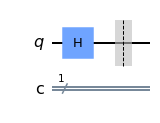

In [6]:
np.random.seed(seed=0)
n = 100

alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)

message = encode_message(alice_bits, alice_bases)

message[0].draw(output='mpl')

## Measuring the Message
When measuring the message we will have to decide whether to measure each bit in the Z or X basis. The type of measurement will be chosen randomly.

In [8]:
def measure_message(message, bases):
    
    measurements = []
    
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        
        aer_sim = Aer.get_backend('aer_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = aer_sim.run(qobj).result()
        
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    
    return measurements

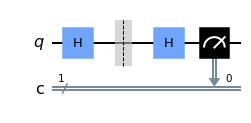

In [10]:
np.random.seed(seed=0)
n = 100

alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

message[0].draw(output='mpl')

## Cleaning the Key
Alice will share the bases she used to encode the message and Bob will share the bases he used to mesaure the message. Using this information, the two can keep the bits that correspond to the correctly guessed bases and ingore the rest. This leave Bob and Alice with their keys.

In [24]:
def remove_garbage(a_bases, b_bases, bits):
    clean_bits = []
    
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            clean_bits.append(bits[q])
   
    return clean_bits

## Sampling the Keys
Alice and Bob sample a random selection of bits from their key. If the bits match, then their keys are ready to use. If the keys do not match then Eve has measured the encoded message in transit.

In [25]:
def sample_bits(bits, selection):
    sample = []
    
    for i in selection:
        i = np.mod(i, len(bits)) # make sure i is in list range
        sample.append(bits.pop(i))
    return sample

## Simulating Key Exchange
In this particular case, 100 qubits were used to generate a key size of only 33 after removing garbage.

In [29]:
np.random.seed(seed=0)
n = 100

# Alice generates encoded message
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

# Bob measures using randomly generated bases
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

# Alice and Bob share the bases they used and clean their keys
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  Bob's sample = " + str(bob_sample))

alice_sample = sample_bits(alice_key, bit_selection)
print("Alice's sample = "+ str(alice_sample))

print("Samples match: "+ str(bob_sample == alice_sample))

  Bob's sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Alice's sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Samples match: True


In [30]:
print(bob_key)
print(alice_key)
print("key length = %i" % len(alice_key))

[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
key length = 33


## Simulating Key Exchange with Eve's Interference
Here, the act of measuring the message as an eavesdropper has disrupted its quantum state. This is easily detected when comparing Alice and Bob's sample size. It will still be possible for Eve to go undetected, so it is important to sample a sufficent number of bits. Now that Alice and Bob know that their encoded message has been observed they can exchange new keys until they are satisfied no-one has seen their message.

In [31]:
np.random.seed(seed=3)
n = 100

# Alice generates encoded message
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

# Eve intercepts
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)

# Bob measures message after interception
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

# Alice and Bob share the bases they used and clean their keys
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

# Alice and Bob sample their results and compare
sample_size = 15 # Increasing the sample size reduces the likelihood of Eve going undetected
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
alice_sample = sample_bits(alice_key, bit_selection)

if bob_sample != alice_sample:
    print("Eve's interference was detected.")
else:
    print("Eve was undetected")

Eve's interference was detected.
